In [1]:
import sys
from pathlib import Path
import importlib.util
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
import scipy.stats as stats
import numpy as np
from scipy.stats import kruskal
import scikit_posthocs as sp
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
from pandas.plotting import table

# notebooks/.. = project_root
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


package_dir = project_root / "scdb_code_map"
init_file = package_dir / "__init__.py"
init_file.touch(exist_ok=True)  # creates empty __init__.py if missing


spec = importlib.util.find_spec("scdb_code_map")
if spec is None:
    raise ImportError(f"Cannot find 'scdb_code_map' in {project_root}")


from scdb_code_map import ISSUE_AREA_MAP

In [2]:
# get data from database
conn = sqlite3.connect("../data/legal_sc.db")
c_citations = pd.read_sql("SELECT * FROM c_citations", conn)
conn.close()
# check size
print(c_citations.shape)

(9341, 53)


In [3]:
# How many unique cases in each issue area
# preferred method = use the citation table because each row is a unique caseID, no duplicate or double counting
# the issueArea will be the main issueArea associated with the case even if it involves multiple issueArea

# 1.0 - 14.0 in issueArea column are the numerical code for 14 different legal areas. For example, Civil Rights is 2
# without sort_index, the default will return a list based on the count from high to low
# sort_index will sort the output by issueArea code from 1.0 to 14.0

print(c_citations["issueArea"].value_counts().sort_index())

cases_per_area = (
    c_citations
    .groupby('issueArea')
    .size()
    .reset_index(name='count')  #convert Series to DataFrame, otherwise it's a series w/o .columns usage, causing mapping error
)


# Rename columns
cases_per_area.columns = ["issueArea", "count"]
print(cases_per_area.columns)

# Map issueArea names, issueAreaName is a new column
cases_per_area['issueAreaName'] = cases_per_area['issueArea'].map(ISSUE_AREA_MAP)

cases_per_area_sorted = cases_per_area.sort_values(by='count', ascending=False)

print("\n", cases_per_area_sorted)


issueArea
1.0     2103
2.0     1516
3.0      707
4.0      362
5.0      122
6.0      104
7.0      373
8.0     1836
9.0     1274
10.0     417
11.0     105
12.0     320
13.0      30
14.0       7
Name: count, dtype: int64
Index(['issueArea', 'count'], dtype='object')

     issueArea  count         issueAreaName
0         1.0   2103    Criminal Procedure
7         8.0   1836     Economic Activity
1         2.0   1516          Civil Rights
8         9.0   1274        Judicial Power
2         3.0    707       First Amendment
9        10.0    417            Federalism
6         7.0    373                Unions
3         4.0    362           Due Process
11       12.0    320      Federal Taxation
4         5.0    122               Privacy
10       11.0    105  Interstate Relations
5         6.0    104             Attorneys
12       13.0     30         Miscellaneous
13       14.0      7           Private Law


In [4]:
# ABANDON using this method to count how many cases in each issue area
# This code is only retained for reference
# still want to computer how many cases in each issue area

# In issues table, one case can have multiple issues and it can appears as multiple rows
# if use c_issues["issueArea"].value_counts() it could count the same case more than once in a given area
# For example, suppose a case involves two issues, both in Civil Rights, we will count it as 2 cases in Civil Rights
# we don't want this
# But if a case involves two issues in different area like Civil Rights and Unions
# It's also not clear what the best way to count should be
# The code below will count this twice, once for each separate issueArea (not necessarily ideal)
# Also there might be other reasons duplicate rows appear in this table for the same caseID, not clear how to deal with it
# And this code doesn't deal with it

# This count method doesn't deal with any duplicate issue
# print(c_issues["issueArea"].value_counts().sort_index())

# This count method only deal with same issueArea duplicate issues

# cases_per_area_ = (
#     c_issues
#     .drop_duplicates(subset=['caseId', 'issueArea'])
#     .groupby('issueArea')
#     .size()
# )

# print("\n", cases_per_area)


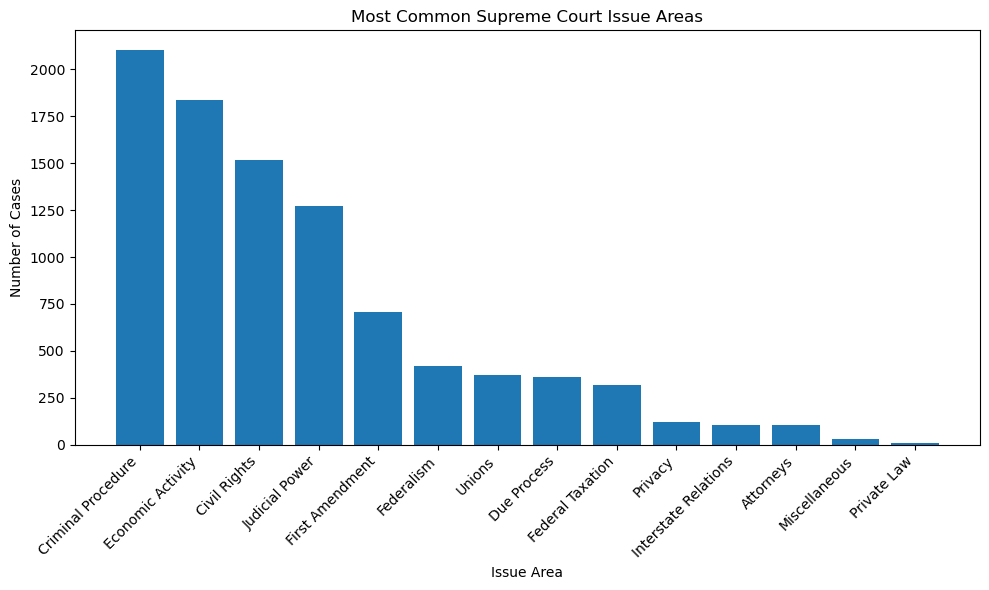

In [5]:
# plot

# Drop rows with missing issueArea or count
# only drop a row if issueArea or count is NaN, but ignore NaNs in other columns
cases_per_area_clean_sorted = cases_per_area_sorted.dropna(subset=["issueArea", "count"])

# Drop rows where mapping failed (i.e., no matching name)
cases_per_area_clean_sorted = cases_per_area_clean_sorted.dropna(subset=["issueAreaName"])

# Plot
plt.figure(figsize=(10,6))
plt.bar(cases_per_area_clean_sorted["issueAreaName"], cases_per_area_clean_sorted["count"])
plt.xlabel("Issue Area")
plt.ylabel("Number of Cases")
plt.title("Most Common Supreme Court Issue Areas")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot as a JPEG
plt.savefig('../results/case_count_vs_issueArea.jpg', format='jpg', dpi=300)

plt.show()

In [6]:
# optional if doing it in sql instead
# only do case area count, not duration, sql does not handle dates as reliably as pandas
conn = sqlite3.connect("../data/legal_sc.db")

# SQL query to compute total cases only
query = """
SELECT issueArea,
       COUNT(*) AS total_cases
FROM c_citations
WHERE dateArgument IS NOT NULL
  AND dateDecision IS NOT NULL
GROUP BY issueArea
ORDER BY total_cases DESC;
"""

# Execute SQL and load into pandas
sql_results = pd.read_sql(query, conn)

# Close the database connection
conn.close()

# Map issueArea to English names
sql_results["issueAreaName"] = sql_results["issueArea"].map(ISSUE_AREA_MAP)

# Optional: reorder columns
sql_results = sql_results[["issueArea", "issueAreaName", "total_cases"]]

# Display the results
print(sql_results)

    issueArea         issueAreaName  total_cases
0         1.0    Criminal Procedure         1765
1         8.0     Economic Activity         1756
2         2.0          Civil Rights         1299
3         9.0        Judicial Power         1066
4         3.0       First Amendment          629
5        10.0            Federalism          382
6         7.0                Unions          364
7         4.0           Due Process          337
8        12.0      Federal Taxation          307
9         5.0               Privacy          111
10        6.0             Attorneys           93
11       11.0  Interstate Relations           70
12        NaN                   NaN           65
13       13.0         Miscellaneous           30
14       14.0           Private Law            5


9341 9276 



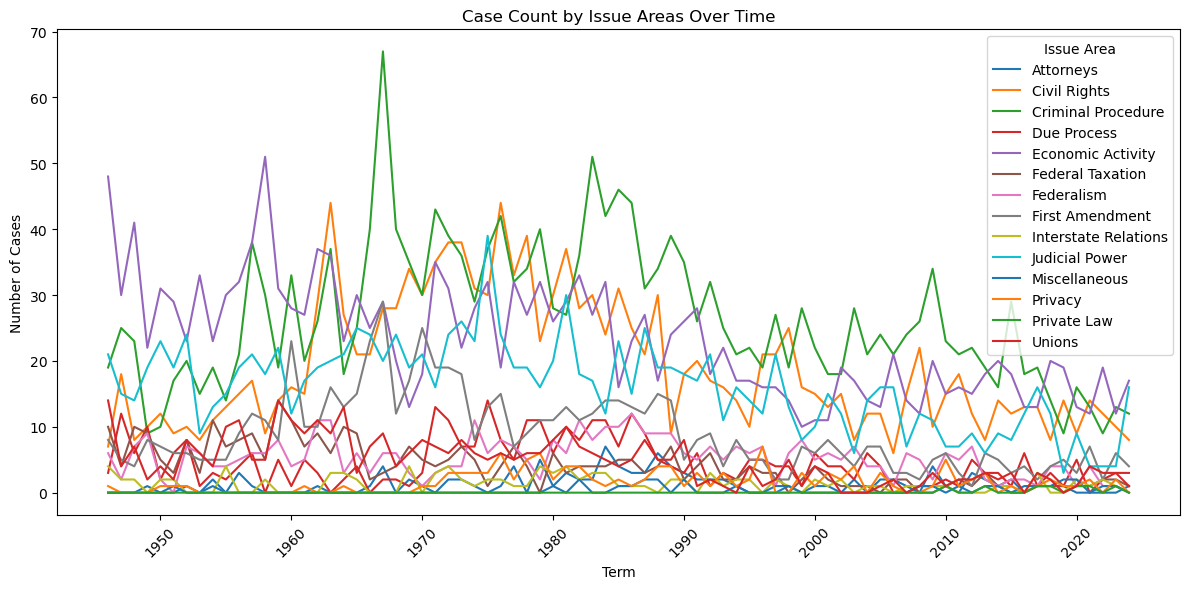

In [7]:
# Has issue type popularity changed over time
# answers questions like are there more civil rights cases now than 3o years ago
# plot number of cases in each area over the years

# Make sure the column exists
if 'issueArea' not in c_citations.columns:
    raise ValueError("Column 'issueArea' not found in issues DataFrame")

# Map numeric codes to English names
c_citations['issueAreaName'] = c_citations['issueArea'].map(ISSUE_AREA_MAP)

# Drop rows where mapping failed (NaN values)
citation_clean = c_citations.dropna(subset=['issueAreaName'])
print(len(c_citations), len(citation_clean), '\n')


# Group by term and mapped issue area name
# the dataframe has the column term = year of the case, and issueAreaName
# Groups the DataFrame by the combination of two columns: year of the case and type of issue
# .size() Counts the number of rows in each group
# returns a Series with a MultiIndex (the grouping columns) and the count as values
# in this case it will have a column for year like 2000
# for year 2000, it will have a column that lists uniquely the issues from that year
# then for each issue occurred in 2000, it will count how many times it happened
# so we have for year 2000, civil rights cases = 10, privacy = 5 etc
# initially this is a Series with a MultiIndex, term and issueAreaName are not regular columns, but part of the Series index
# after .reset_index(name='case_count'), the MultiIndex is moved into columns, the count values become a new column (case_count)
issue_trends = (
    citation_clean
    .groupby(['term', 'issueAreaName'])
    .size()
    .reset_index(name='case_count')
)

# Pivot for plotting
# before pivot, I have a dataframe with three Columns: 'term', 'issueAreaName', 'case_count'
# each row is a unique combination of term and issueAreaName, but a single column like term has values that's not unique
# year 2000 can appear in multiple rows 'cause I have a row for 2000 civil rights, then another row for 2000 privacy
# after pivot, the term/year become unique index and there is now only a single row for each year
# instead now I have 14 columns or a much wider dataframe corresponding to 14 issue areas
# so the table looks like for year 2000, civil rights has 10 cases, privacy has 5 cases
# now if I plot this, the x-axis is term, then I get a separate line for each column/separate issue area
pivot = issue_trends.pivot(
    index='term',
    columns='issueAreaName',
    values='case_count'
).fillna(0)

# Plot
# pandas automatically uses the DataFrame index as the x-axis, which is the term/year. Each column yield a separate line
pivot.plot(figsize=(12,6))
plt.xlabel("Term")
plt.ylabel("Number of Cases")
plt.title("Case Count by Issue Areas Over Time")
plt.xticks(rotation=45)
plt.legend(title="Issue Area")
plt.tight_layout()

plt.savefig('../results/case_count_per_area_over_time.jpg', format='jpeg', dpi=300)
plt.show()

In [8]:
# Issue Duration
# converts the dateArgument column in the issues DataFrame into pandas datetime objects
# something like "March 3, 2024" becomes 2024-03-03 00:00:00 
# "coerce": invalid dates become NaT
# dateArgument  → oral hearing
# dateDecision  → final ruling

c_citations["dateArgument"] = pd.to_datetime(c_citations["dateArgument"], errors="coerce")
c_citations["dateDecision"] = pd.to_datetime(c_citations["dateDecision"], errors="coerce")

#.dt.days extracts the number of whole days from a pandas timedelta value, returns integer
# the original timedelta series can look like 62 days, 89 days, it's not integer
# timedelta object can also look like 3 days 23:59:59
# force the duration to integer type, otherwaise a single NaT value in dateDecision or dateArgument
# will cause all case_duration_days to be a float

c_citations["case_duration_days"] = (
    c_citations["dateDecision"] - c_citations["dateArgument"]
).dt.days.astype("Int64")

# describe() ignores NA values  by default, so the printed count value is 8279 cases, less than 9341 total cases in the database
print(f"Total number of unique cases in the database is: {len(c_citations)}")
print(f"Case with NA date values are dropped, resulting in fewer cases being used for duration analysis")
print(c_citations["case_duration_days"].describe())

Total number of unique cases in the database is: 9341
Case with NA date values are dropped, resulting in fewer cases being used for duration analysis
count       8279.0
mean     90.882353
std      65.377146
min            0.0
25%           53.0
50%           77.0
75%          112.0
max          799.0
Name: case_duration_days, dtype: Float64


In [9]:
# Duration by type

c_citations['issueAreaName'] = c_citations['issueArea'].map(ISSUE_AREA_MAP)
# Drop rows where mapping failed (NaN values)
citations_clean = c_citations.dropna(subset=['issueAreaName'])
# duration_by_issue = (
#     citations_clean
#     .groupby("issueAreaName")["case_duration_days"]
#     .mean()
#     .reset_index()
# )

duration_by_issue = (
    citations_clean
    .groupby("issueAreaName")["case_duration_days"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .reset_index()
)

print(duration_by_issue)

# Intepretation
# Due Process, First Amendment, Miscellaneous, Privacy areas tend to have cases that last longer
# Federal Taxation have shorter cases

           issueAreaName  count        mean  median        std  min  max
0              Attorneys     93   93.763441    77.0  61.458611    4  480
1           Civil Rights   1299   98.612009    84.0  68.908251    1  595
2     Criminal Procedure   1765   93.930878    82.0  62.397279    0  769
3            Due Process    337  105.243323    90.0  70.738074    8  593
4      Economic Activity   1756   84.290433    72.0  56.119814    4  799
5       Federal Taxation    307   76.820847    66.0  65.071684    3  671
6             Federalism    382   83.442408    75.0  47.304293    4  335
7        First Amendment    629  111.586645    93.0  78.313641    3  768
8   Interstate Relations     70        84.6    70.5  64.813087    4  466
9         Judicial Power   1066   79.136961    64.0  67.722896    3  714
10         Miscellaneous     30  122.866667   105.5  91.652919   21  486
11               Privacy    111  112.900901    99.0  63.220962   32  406
12           Private Law      5       119.6   134.0

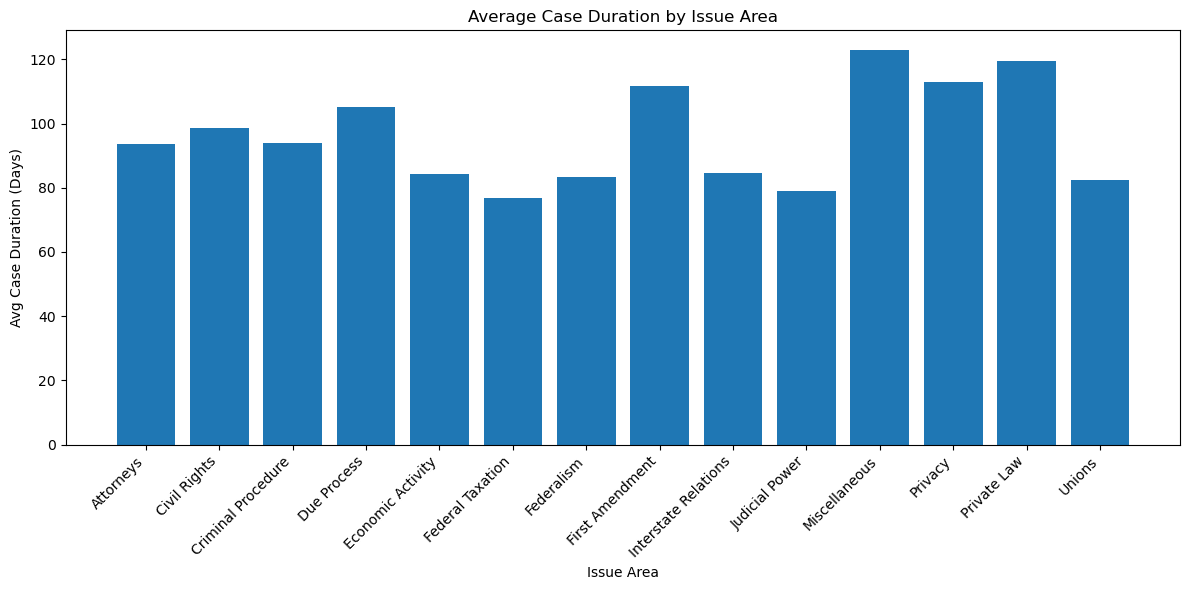

In [10]:
# plot duration by type
plt.figure(figsize=(12,6))  # Optional: make the figure wider to fit labels
plt.bar(duration_by_issue["issueAreaName"], duration_by_issue["mean"])
plt.xlabel("Issue Area")
plt.ylabel("Avg Case Duration (Days)")
plt.title("Average Case Duration by Issue Area")

plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align them to the right
plt.tight_layout()  # Adjust layout so labels don’t get cut off
plt.savefig('../results/case_duration.jpg', format='jpg', dpi=300)
plt.show()

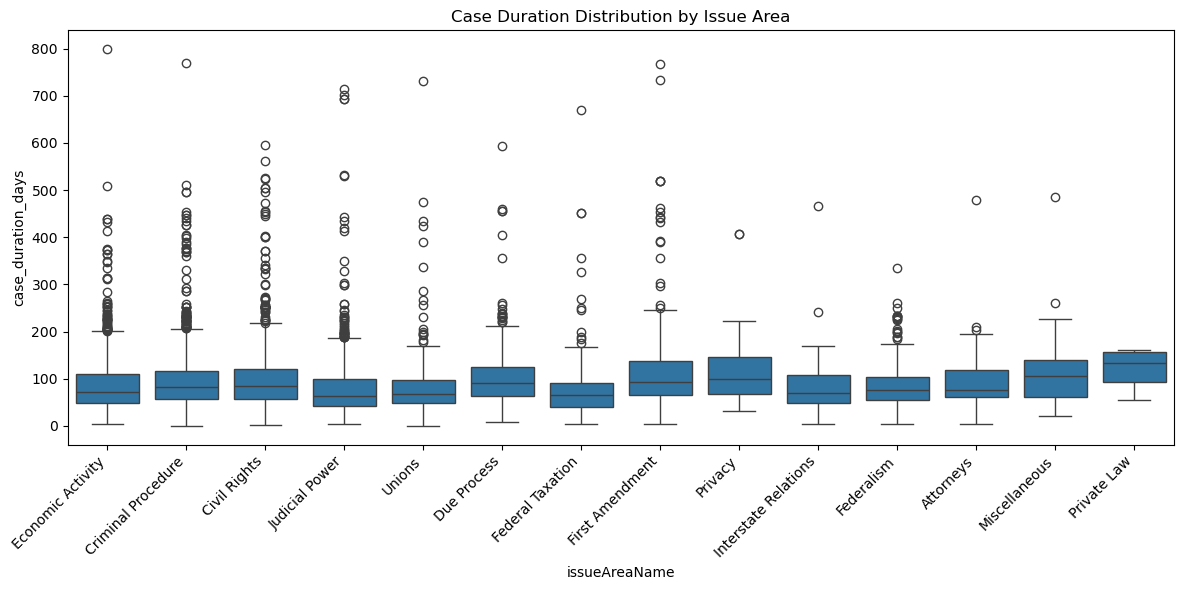

In [11]:
# Boxplot that can capture more info than just the mean duration for each area

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=citations_clean,
    x="issueAreaName",
    y="case_duration_days"
)
plt.xticks(rotation=45, ha="right")
plt.title("Case Duration Distribution by Issue Area")
plt.tight_layout()
plt.savefig('../results/case_duration_boxplot.jpg', format='jpg', dpi=300)
plt.show()

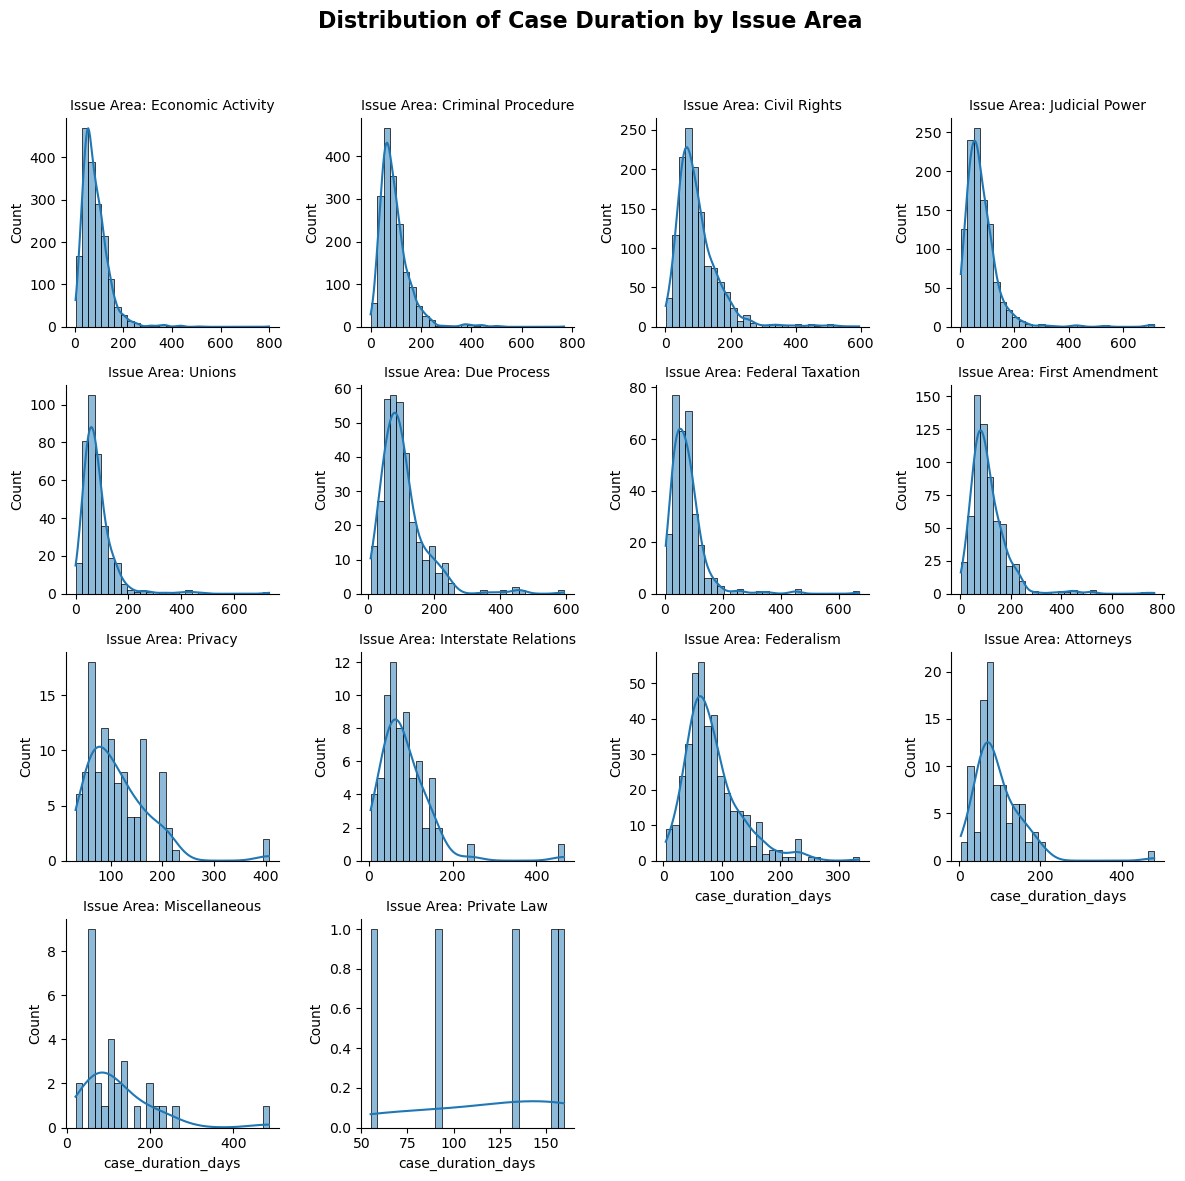

In [12]:
# Take a look at the actual case duration distribution for each area

g = sns.FacetGrid(
    citations_clean,
    col="issueAreaName",
    col_wrap=4,
    height=3,
    sharex=False,
    sharey=False
)

g.map_dataframe(
    sns.histplot,
    x="case_duration_days",
    kde=True,
    bins=30
)

# Set per-facet titles
g.set_titles(col_template="Issue Area: {col_name}")

# Set big title for the entire figure
g.fig.suptitle("Distribution of Case Duration by Issue Area", fontsize=16, fontweight='bold', y=0.98)

# Adjust layout so title is not cut off
# g.fig.tight_layout()
g.fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
plt.savefig('../results/case_duration_distribution_by_area.jpg', format='jpg', dpi=300)
plt.show()

In [13]:
# Does case duration differ by issue area?
# asking whether the mean case duration observed in different area come from the same distribution with the same mean
# Distribution above does not resemble normal distributions
# use Kruskal–Wallis test instead of ANOVA

citations_clean = citations_clean.dropna(subset=['case_duration_days'])

# create a list of arrays, one for each area
groups = [
    citations_clean.loc[citations_clean['issueAreaName'] == area, 'case_duration_days'].values
    for area in citations_clean['issueAreaName'].unique()
]

# Filter out groups with fewer than 2 values
groups = [g for g in groups if len(g) >= 2]

print(f"Number of valid groups: {len(groups)}")

# Perform Kruskal-Wallis test
if len(groups) >= 2:  # Need at least 2 groups to compare
    H, p = kruskal(*groups)
    print(f"Kruskal-Wallis H-statistic: {H:.4f}")
    print(f"p-value: {p:.4f}")

    if p < 0.05:
        print("Result: At least one group's distribution differs (reject H0)")
    else:
        print("Result: No significant difference between groups (fail to reject H0)")
else:
    print("Not enough groups with sufficient data to perform Kruskal-Wallis test.")

# Interpretation
# H-Statistics = 311 is very large, A large H means the groups’ distributions differ a lot.
# This suggests strong differences in case duration distributions among the 14 areas. 
# At least one of the 14 issue areas has a different case duration distribution compared to the others
# But we don't know which

Number of valid groups: 14
Kruskal-Wallis H-statistic: 311.0114
p-value: 0.0000
Result: At least one group's distribution differs (reject H0)


In [14]:
# Look into size effect using the Kruskal-Wallis H-statistic
# compute Epsilon-squared (ε²)
# Interpretation of Epsilon-squared (ε²) --> 0.01 (Small), 0.08 (Medium), 0.26 (Large)

# Number of groups
k = citations_clean["issueAreaName"].nunique()

# Total sample size
n = len(citations_clean)

epsilon_squared = (H - k + 1) / (n - k)

print(f"Epsilon-squared (ε²): {epsilon_squared:.4f}")

# observation
# Epsilon-squared (ε²) = 0.0363
# About 3.6% of the variability in case_duration_days 
# is associated with differences between issueAreaName groups, based on the Kruskal–Wallis test.

Epsilon-squared (ε²): 0.0363


In [15]:
# Alternatively, one can compute the onparametric analogue of η² (eta-squared) from ANOVA.
# This is less preferred than Epsilon-squared (ε²) given the test is Kruskal-Wallis, not ANOVA
# But sometimes it can be useful if one wishes to compare the result to ANOVA literature
eta_squared = H / (n - 1)

print(f"Eta-squared (η²): {eta_squared:.4f}")

Eta-squared (η²): 0.0379


In [16]:
# Since Kruskal–Wallis test is significant
# Follow up with Dunn's post-hoc test with Bonferroni correction
# this will perform pairwise comparison to find which issue areas differ from each other.
posthoc = sp.posthoc_dunn(
    citations_clean,
    val_col='case_duration_days',
    group_col='issueAreaName',
    p_adjust='bonferroni'
)

print(posthoc.head())

# Interpretation
# The output is a 14 × 14 matrix
# Each cell is an adjusted p-value
# Diagonal = 1.0 (same group)
# p < 0.05 → the two issue areas differ significantly

                    Attorneys  Civil Rights  Criminal Procedure   Due Process  \
Attorneys                 1.0  1.000000e+00            1.000000  1.000000e+00   
Civil Rights              1.0  1.000000e+00            1.000000  1.000000e+00   
Criminal Procedure        1.0  1.000000e+00            1.000000  2.329874e-01   
Due Process               1.0  1.000000e+00            0.232987  1.000000e+00   
Economic Activity         1.0  4.112597e-08            0.000009  1.462187e-07   

                    Economic Activity  Federal Taxation  Federalism  \
Attorneys                1.000000e+00      3.386336e-02    1.000000   
Civil Rights             4.112597e-08      1.351007e-10    0.040690   
Criminal Procedure       9.147485e-06      8.657686e-09    0.528579   
Due Process              1.462187e-07      1.842524e-11    0.000673   
Economic Activity        1.000000e+00      3.245426e-02    1.000000   

                    First Amendment  Interstate Relations  Judicial Power  \
Attorneys

In [17]:
# Make the table slightly easier to read by converting it to True or False with 0.05 threshold
posthoc_significant = posthoc < 0.05
print(posthoc_significant.head())

                    Attorneys  Civil Rights  Criminal Procedure  Due Process  \
Attorneys               False         False               False        False   
Civil Rights            False         False               False        False   
Criminal Procedure      False         False               False        False   
Due Process             False         False               False        False   
Economic Activity       False          True                True         True   

                    Economic Activity  Federal Taxation  Federalism  \
Attorneys                       False              True       False   
Civil Rights                     True              True        True   
Criminal Procedure               True              True       False   
Due Process                      True              True        True   
Economic Activity               False              True       False   

                    First Amendment  Interstate Relations  Judicial Power  \
Attorneys      

In [18]:
# convert table to long format to improve readability
posthoc_long = posthoc.reset_index().melt(
    id_vars='index',
    var_name='Group 2',
    value_name='Adjusted p-value'
).rename(columns={'index': 'Group 1'})

significant_pairs = posthoc_long[posthoc_long['Adjusted p-value'] < 0.05]
print(significant_pairs)

                Group 1       Group 2  Adjusted p-value
5      Federal Taxation     Attorneys      3.386336e-02
18    Economic Activity  Civil Rights      4.112597e-08
19     Federal Taxation  Civil Rights      1.351007e-10
20           Federalism  Civil Rights      4.069027e-02
21      First Amendment  Civil Rights      1.890227e-04
..                  ...           ...               ...
183        Civil Rights        Unions      1.381426e-06
184  Criminal Procedure        Unions      5.637761e-05
185         Due Process        Unions      6.295618e-08
189     First Amendment        Unions      7.446207e-16
193             Privacy        Unions      1.311377e-07

[68 rows x 3 columns]


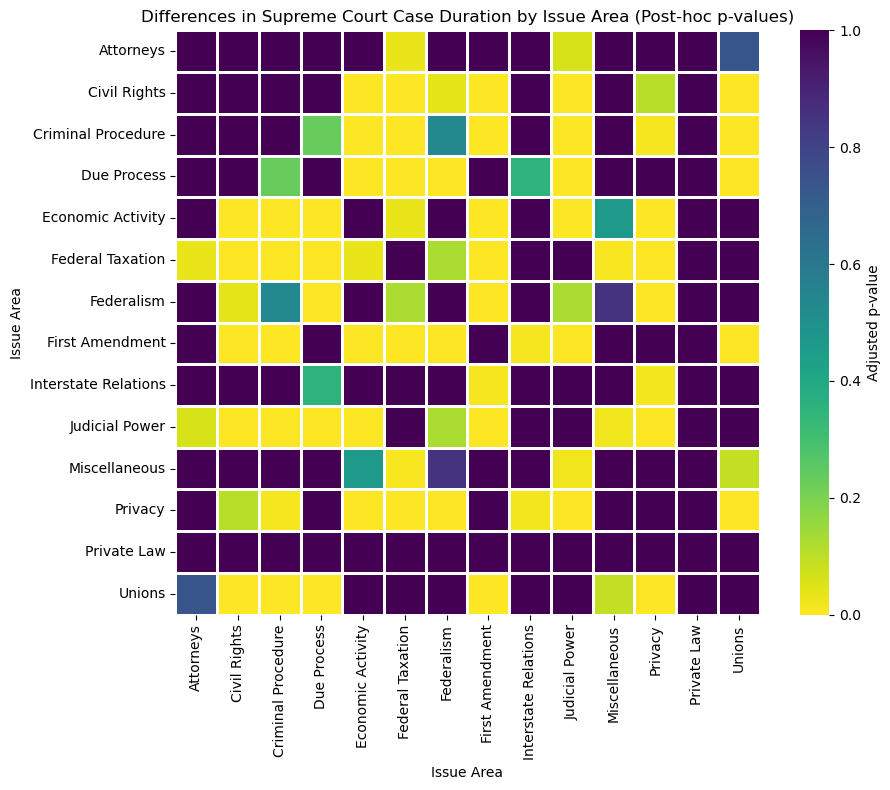

In [19]:
# use heat map to visualize post-hoc test result
# Dark cells → small p-values → strong differences
# Light cells → large p-values → similar distributions
# Diagonal = same group (p = 1)

plt.figure(figsize=(10, 8))

sns.heatmap(
    posthoc,
    cmap="viridis_r",
    square=True,
    linewidths=0.8,          # thickness of grid lines
    linecolor="white",       # color of grid lines
    cbar_kws={'label': 'Adjusted p-value'}
)

plt.title("Differences in Supreme Court Case Duration by Issue Area (Post-hoc p-values)")
plt.xlabel("Issue Area")
plt.ylabel("Issue Area")
plt.tight_layout()
plt.savefig('../results/case_duration_difference_posthoc_by_area.jpg', format='jpg', dpi=300)
plt.show()

In [20]:
# Are case duration correlated with other things besides issues areas such as
# who the chief is, whether it has a 5/4 vote instead of unanimous, or the lawtype involved
# depending on if those other columns are numerical, binary, or categorical, different tests are used

# First identify relevant factors/columns by type

numeric_cols = [
    "majVotes",
    "term",
    "naturalCourt"
]

binary_cols = [
    "splitVote",
    "threeJudgeFdc",
    "declarationUncon",
    "caseDispositionUnusual",
    "voteUnclear",
    "precedentAlteration"
]

categorical_cols = [
    "lawType",
    "lawSupp",
    "lawMinor",
    "issue",
    "issueArea",
    "decisionType",
    "decisionDirection",
    "jurisdiction",
    "petitioner"
]

# petitioner type might have too many categories, uneven group size, some categories with very few case
# This can inflate H and distort Epsilon-squared (ε²) from Kruskal-Wallis test
# so filter out the really uncommon petitioner types
min_n = 20

df_pet = citations_clean[
    citations_clean["petitioner"].map(
        citations_clean["petitioner"].value_counts()
    ) >= min_n
]

In [21]:
# Do Spearman correlation for numeric predictors (numeric_cols)

results = []

for col in numeric_cols:
    df_tmp = citations_clean[[col, "case_duration_days"]].dropna()
    rho, p = spearmanr(df_tmp[col], df_tmp["case_duration_days"])
    
    results.append({
        "variable": col,
        "test": "Spearman",
        "effect_size": rho,
        "p_value": p
    })

# Do Mann–Whitney U + rank-biserial r for Binary predictors (binary_cols)

for col in binary_cols:
    df_tmp = citations_clean[[col, "case_duration_days"]].dropna()
    groups = df_tmp[col].unique()
    
    if len(groups) == 2:
        g1 = df_tmp[df_tmp[col] == groups[0]]["case_duration_days"]
        g2 = df_tmp[df_tmp[col] == groups[1]]["case_duration_days"]
        
        U, p = mannwhitneyu(g1, g2, alternative="two-sided")
        n1, n2 = len(g1), len(g2)
        
        # Rank-biserial correlation
        r = 1 - (2 * U) / (n1 * n2)
        
        results.append({
            "variable": col,
            "test": "Mann–Whitney",
            "effect_size": r,
            "p_value": p
        })

# Do Kruskal–Wallis for Categorical predictors (categorical_cols)

for col in categorical_cols:
    df_tmp = citations_clean[[col, "case_duration_days"]].dropna()
    
    groups = [
        g["case_duration_days"].values
        for _, g in df_tmp.groupby(col)
        if len(g) > 1
    ]
    
    if len(groups) > 1:
        H, p = kruskal(*groups)
        k = df_tmp[col].nunique()
        n = len(df_tmp)
        
        epsilon_sq = (H - k + 1) / (n - k)
        
        results.append({
            "variable": col,
            "test": "Kruskal–Wallis",
            "effect_size": epsilon_sq,
            "p_value": p
        })

# Combine and inspect results

results_df = pd.DataFrame(results)

# Negative effect_size is basically zero, correct this
results_df_clean = results_df.copy()

# Truncate epsilon-squared at zero
mask = results_df_clean["test"] == "Kruskal–Wallis"

results_df_clean.loc[mask, "effect_size"] = (
    results_df_clean.loc[mask, "effect_size"].clip(lower=0)
)

case_duration_correlation = results_df_clean.sort_values(
    by="effect_size",
    key=abs,
    ascending=False
)

# print and save the output table
print(case_duration_correlation)
dfi.export(
    case_duration_correlation.style.hide(axis='index'), 
    '../results/tbl_case_duration_correlation_summary.jpg', 
    table_conversion='matplotlib'
)

# Interpretation:
# The followinf show strongest effects on caseduration:
# majority votes, natural court, term, precedent alteration, and issue-related factors

                  variable            test  effect_size        p_value
0                 majVotes        Spearman    -0.283003  4.257318e-151
2             naturalCourt        Spearman     0.256124  3.500257e-123
1                     term        Spearman     0.253915  4.979570e-121
6      precedentAlteration    Mann–Whitney    -0.251309   2.514986e-09
5              voteUnclear    Mann–Whitney     0.130269   4.205932e-02
4   caseDispositionUnusual    Mann–Whitney     0.098426   5.291935e-02
10                   issue  Kruskal–Wallis     0.085377   1.084389e-80
12            decisionType  Kruskal–Wallis     0.076649  1.002423e-135
8                  lawSupp  Kruskal–Wallis     0.063046   5.984518e-58
3            threeJudgeFdc    Mann–Whitney     0.060709   2.554351e-02
15              petitioner  Kruskal–Wallis     0.041821   3.350598e-34
11               issueArea  Kruskal–Wallis     0.036343   1.190296e-58
7                  lawType  Kruskal–Wallis     0.035265   1.393854e-54
14    

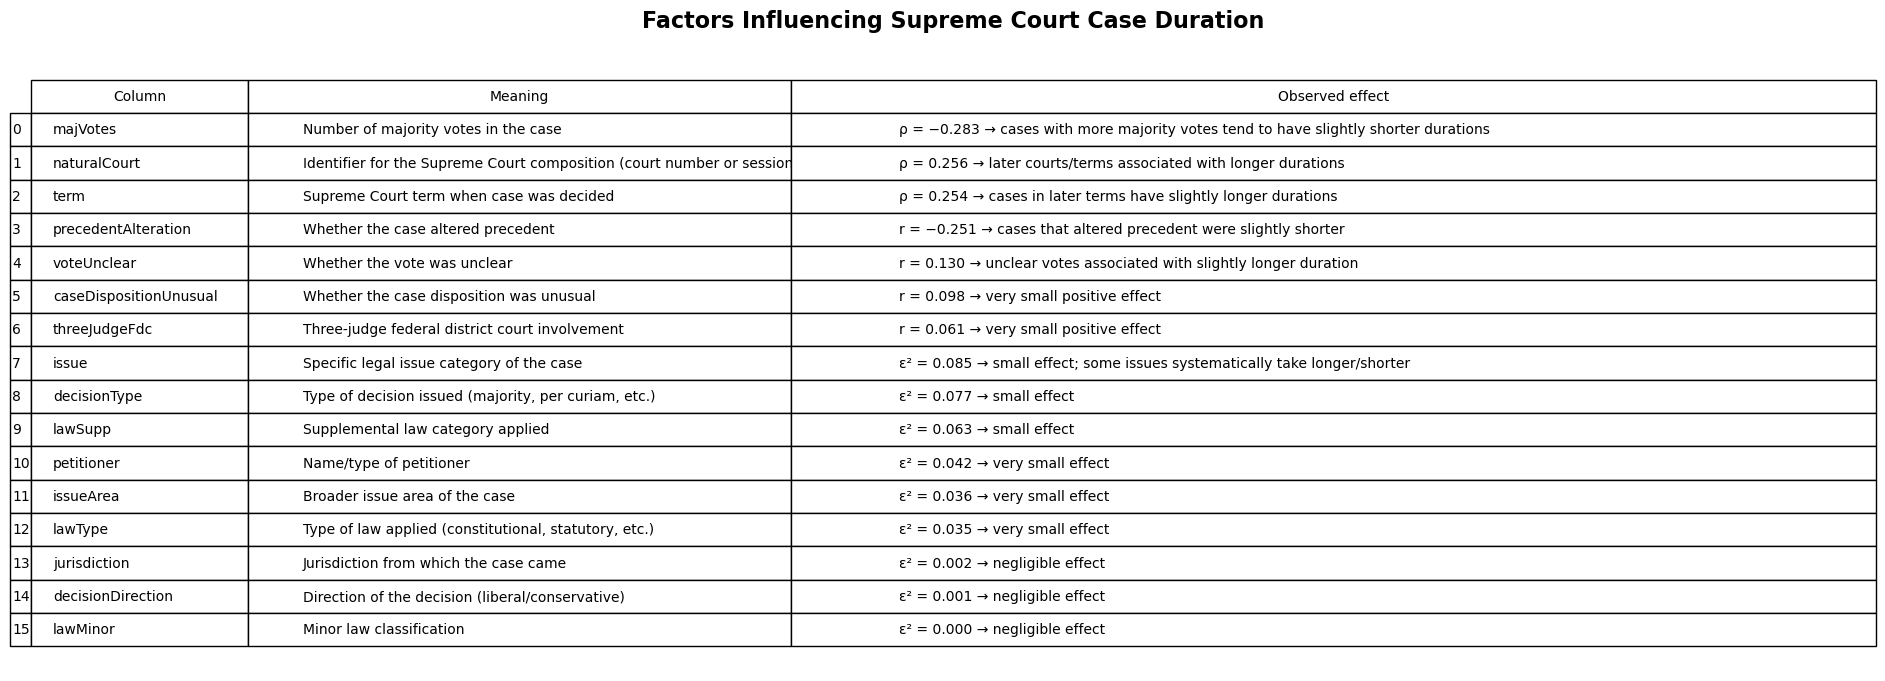

In [22]:
# write the result and interpretation into a table

# Create a list of dictionaries with all the variables
data = [
    # Numeric
    {"Column":"majVotes", "Meaning":"Number of majority votes in the case",
     "Observed effect":"ρ = −0.283 → cases with more majority votes tend to have slightly shorter durations"},
    {"Column":"naturalCourt", "Meaning":"Identifier for the Supreme Court composition (court number or session)",
     "Observed effect":"ρ = 0.256 → later courts/terms associated with longer durations"},
    {"Column":"term", "Meaning":"Supreme Court term when case was decided",
     "Observed effect":"ρ = 0.254 → cases in later terms have slightly longer durations"},
    
    # Binary
    {"Column":"precedentAlteration", "Meaning":"Whether the case altered precedent",
     "Observed effect":"r = −0.251 → cases that altered precedent were slightly shorter"},
    {"Column":"voteUnclear", "Meaning":"Whether the vote was unclear",
     "Observed effect":"r = 0.130 → unclear votes associated with slightly longer duration"},
    {"Column":"caseDispositionUnusual", "Meaning":"Whether the case disposition was unusual",
     "Observed effect":"r = 0.098 → very small positive effect"},
    {"Column":"threeJudgeFdc", "Meaning":"Three-judge federal district court involvement",
     "Observed effect":"r = 0.061 → very small positive effect"},
    
    # Categorical
    {"Column":"issue", "Meaning":"Specific legal issue category of the case",
     "Observed effect":"ε² = 0.085 → small effect; some issues systematically take longer/shorter"},
    {"Column":"decisionType", "Meaning":"Type of decision issued (majority, per curiam, etc.)",
     "Observed effect":"ε² = 0.077 → small effect"},
    {"Column":"lawSupp", "Meaning":"Supplemental law category applied",
     "Observed effect":"ε² = 0.063 → small effect"},
    {"Column":"petitioner", "Meaning":"Name/type of petitioner",
     "Observed effect":"ε² = 0.042 → very small effect"},
    {"Column":"issueArea", "Meaning":"Broader issue area of the case",
     "Observed effect":"ε² = 0.036 → very small effect"},
    {"Column":"lawType", "Meaning":"Type of law applied (constitutional, statutory, etc.)",
     "Observed effect":"ε² = 0.035 → very small effect"},
    {"Column":"jurisdiction", "Meaning":"Jurisdiction from which the case came",
     "Observed effect":"ε² = 0.002 → negligible effect"},
    {"Column":"decisionDirection", "Meaning":"Direction of the decision (liberal/conservative)",
     "Observed effect":"ε² = 0.001 → negligible effect"},
    {"Column":"lawMinor", "Meaning":"Minor law classification",
     "Observed effect":"ε² = 0.000 → negligible effect"},
]

# Convert to DataFrame
df_summary = pd.DataFrame(data)

# Save to CSV
fig, ax = plt.subplots(figsize=(14,8))
ax.axis('off')

# Add title
ax.set_title("Factors Influencing Supreme Court Case Duration", 
             fontsize=16, fontweight='bold', pad=20)

# Create table
tbl = table(ax, df_summary, loc='center', cellLoc='left', colWidths=[0.2,0.5,1])
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 2)

# Save as JPEG
plt.savefig("../results/tbl_case_duration_correlation_interpretation.jpg", 
            bbox_inches='tight', dpi=300)
plt.show()

In [3]:
# check if there are months when the Supreme Court hears more cases
# use dateArgument column

# ensure dateArgument is a datetime
c_citations['dateArgument'] = pd.to_datetime(
    c_citations['dateArgument'], errors='coerce'
)

# drop cases with no argument date
c_citations_clean = c_citations.dropna(
    subset=['dateArgument']
).copy()

# get the month value
c_citations_clean['argument_month'] = (
    c_citations_clean['dateArgument'].dt.month
)

# could number of cases from each month
monthly_counts = (
    c_citations_clean.groupby('argument_month')
      .size()
      .reset_index(name='num_cases')
      .sort_values('argument_month')
)

# convert the month from numerical value to name
monthly_counts['argument_month'] = pd.to_datetime(
    monthly_counts['argument_month'], format='%m'
).dt.month_name()

print(monthly_counts)

# Interpretation
# Oral arguments are heavily concentrated in specific months of the Court’s calendar year. 
# Arguments peak in October, November, January, March, and April
# while arguments are virtually nonexistent between June and September due to the Court’s sitting and recess schedule

   argument_month  num_cases
0         January       1223
1        February        815
2           March       1364
3           April       1207
4             May         97
5            June          5
6            July          2
7          August          1
8       September          2
9         October       1295
10       November       1339
11       December        929


In [4]:
# save the table above

# rename columns for readability
monthly_counts = monthly_counts.rename(columns={
    'argument_month': 'Argument Month',
    'num_cases': 'Number of Cases'
})

# drop the index
monthly_counts = monthly_counts.reset_index(drop=True)

# create figure
fig, ax = plt.subplots(figsize=(5, 4))
ax.axis('off')

# add title
ax.set_title(
    "Number of Supreme Court Oral Arguments by Month",
    fontsize=14,
    pad=12
)

# create table
table = ax.table(
    cellText=monthly_counts.values,
    colLabels=monthly_counts.columns,
    cellLoc='left',  # aligns all cells to the left
    colLoc='left',   # aligns column headers to the left
    loc='center'
)

# improve readability
table.auto_set_font_size(False)
table.set_fontsize(10)

# save as JPEG
plt.savefig(
    "../results/tbl_monthly_supreme_court_arguments.jpg",
    dpi=300,
    bbox_inches='tight'
)
plt.close()